# Process optimization by genetic algorithm

job assignment problem

## Preparation

In [37]:
include("../../src/ProcGA.jl")

Main.ProcGA

In [8]:
using CSV,DelimitedFiles
using DataFrames,Missings
using Statistics
using Random

In [9]:
using Plots

In [10]:
gr()

Plots.GRBackend()

## machine data

Read machine definition table.
Jobs column defines which object to product.

In [11]:
ptbl = CSV.read("machine.csv",header = 1)

,name,jobs
,String⍰,String⍰
1,machine1,[1;2;3;4;5]
2,machine2,[6;7;8;9;10;11]
3,machine3,[1;2;3;4;5;6;7;8;9;10;11]


Read object table, these will be producted by those machines.
Pcs means how many objects is made by 1 injection shot.

In [12]:
assignlist =[ eval(Meta.parse(x)) for x in ptbl[:jobs]]

3-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 5]                    
 [6, 7, 8, 9, 10, 11]               
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [13]:
otbl = CSV.read("objtable.csv",header=1)

,job,Ctmin,pc,hour,shot,qty,runday,shotlimit,useday,interval
,String⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,SS,1.5,2,15,600,4000,4,800,2,1
2,AS1,1.5,2,15,600,7000,6,800,2,1
3,AS2,1.5,2,15,600,7000,6,800,2,1
4,TS,1.5,2,15,600,3000,3,800,2,1
5,BS,1.5,1,15,600,700,2,800,2,1
6,CL1,2.0,2,15,450,4000,5,800,2,1
7,CL2,2.0,2,15,450,4000,5,800,2,1
8,ACL,2.0,2,15,450,60,1,800,2,1
9,BCL,2.0,2,15,450,600,1,800,2,1


In [41]:
intervallist = Array{Int,1}(otbl[:interval]);

## make schedule base

In [15]:
# create joblist from object table
jlst = Array{Int,1}()
for i in 1:size(otbl,1)
    v = repeat([i],ceil(Int, otbl[:runday][i]))
    append!(jlst,v)
end

Assign this list to machines.

In [16]:
# columns needed to store enough assign table.
# do not give much
xcol = length(jlst)*3

105

In [17]:
v = zeros(Int,xcol)
for j in 1:length(jlst)
    v[j] = jlst[j]
end

In [18]:
# assign joblist to g0
g0 = [v]
for i in 1:size(ptbl,1)-1
    push!(g0,deepcopy(v))
end

In [19]:
g0

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

assign it correctly.

In [21]:
ProcGA.assignjob!(g0,assignlistgnlist)
ProcGA.orderjob!(g0)
ProcGA.condensejob!(g0)

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [22]:
vm = ProcGA.validlength(g0)

42

In [27]:
# limit max column to vm, so that scheduling does in this range
g1 = [x[1:vm] for x in g0]

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  4, 4, 4, 4, 4, 4, 5, 5, 5, 5]  
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  9, 10, 11, 0, 0, 0, 0, 0, 0, 0]

## Defining penalty functions

You can give your own penalty function when needed.

In [29]:
gs = deepcopy(g1)

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  4, 4, 4, 4, 4, 4, 5, 5, 5, 5]  
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  9, 10, 11, 0, 0, 0, 0, 0, 0, 0]

### bad assignment

In [23]:
ProcGA.listbadassign(g0,assignlist) # implement this!

### continuous overuse

In [30]:
useday = Array{Int,1}(otbl[:useday])
useday'

1×11 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 2  2  2  2  2  2  2  2  2  2  2

Penalty table which excess useday.

In [26]:
ProcGA.listoveruse(g1,1,2)

3-element Array{Array{Int64,1},1}:
 [0, 0, 1, 2, 3, 4, 5, 6, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, 2, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
pl = ProcGA.listoveruse(g1,useday)

3-element Array{Array{Int64,1},1}:
 [0, 0, 1, 2, 3, 4, 5, 6, 3, 4  …  0, 0, 1, 2, 3, 4, 0, 0, 1, 2]
 [0, 0, 1, 2, 3, 4, 5, 6, 7, 8  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, 2, 0, 0, 1, 2, 3, 4  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

This can be used as a penalty point.

In [39]:
sum(sum(pl))

299

### intervals

In [42]:
pl = ProcGA.listshortinterval(g1,intervallist)

3-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
sum(sum(pl))

0

### duplication

In [44]:
pdup = ProcGA.listcoldup(g1)

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 0, 0, 0, 0, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [6, 6, 6, 6, 0, 0, 0, 0, 6, 6  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 0, 0, 0, 0, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [709]:
sum(sum(pdup))

18

### homogeniousness 

In [710]:
g1

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  4, 4, 4, 4, 4, 4, 5, 5, 5, 5]  
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  9, 10, 11, 0, 0, 0, 0, 0, 0, 0]

In [711]:
ph = ProcGA.listhomogenious(g1)

3-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [365]:
ph'

1×105 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0

### sparceness (zero inside validlength)

In [712]:
pz = ProcGA.listzero(g1)

3-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### summing all

In [713]:
# combination of penalties
# using usehour, intervals
function mylistpenalty(tbl)
    pcont = ProcGA.listcontinuity(tbl,useday)
    pz = ProcGA.listzero(tbl)
    prest = ProcGA.listshortinterval(tbl)
    pdup = ProcGA.listduplicate(tbl)
    ph = ProcGA.listhomogenious(tbl)
    
    pall = pcont .+ pz .+ prest .+ ph .+ pdup.* 10 # weight
    pall
end

mylistpenalty (generic function with 1 method)

In [722]:
pt = mylistpenalty(g1)

3-element Array{Array{Int64,1},1}:
 [10, 10, 11, 12, 3, 4, 5, 6, 10, 10  …  0, 0, 1, 2, 3, 4, 0, 0, 1, 2]
 [10, 10, 11, 12, 3, 4, 5, 6, 17, 18  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [10, 10, 11, 12, 0, 0, 1, 2, 13, 14  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [717]:
sum(sum(pt))

432

In [718]:
ProcGA.listpenalty(jtbl::Array{Array{Int,1},1}) = mylistpenalty(jtbl)

Set penalty to sum of penalty table and validlength plus its standard deviation weighted.

In [719]:
ProcGA.penalty(tbl) = sum(sum(mylistpenalty(tbl))) + Int(round(std(ProcGA.validlength.(tbl))))

In [721]:
ProcGA.penalty(g1)

439

## Initialize population

In [371]:
savedfile = "bestprc_heuristics.csv"

"bestprc_heuristics.csv"

In [778]:
# create population from savedfile or make new
if isfile(savedfile)
    println("read from $savedfile")
    gbs = readdlm(savedfile, ',', Int)
    g1 = [gbs[i,:] for i in 1:size(gbs,1) ]
else
    println("Use \"genes\" above.")
end
ProcGA.colsortjob!(g1)

read from bestprc_heuristics.csv


3-element Array{Array{Int64,1},1}:
 [2, 3, 2, 2, 2, 2, 3, 2, 3, 2  …  5, 2, 1, 3, 3, 5, 3, 5, 1, 3]     
 [0, 0, 6, 6, 6, 6, 6, 7, 6, 7  …  7, 10, 8, 10, 11, 7, 9, 6, 10, 11]
 [0, 4, 1, 1, 2, 2, 1, 2, 2, 2  …  3, 3, 7, 4, 3, 5, 6, 7, 8, 7]     

Make population.
Half of it is from best data and latter half is randomly made.

In [779]:
if isfile(savedfile)
    ppl = ProcGA.populatefrom(g1,50);
    ppl = vcat(ppl, ProcGA.populateshuffle(g1,150));
else
    ppl = ProcGA.populateshuffle(g1,200);
end
length(ppl)

200

## Evolution!

In [780]:
# first sort ppl by their penalties
ProcGA.sortpopulation!(ppl);

In [781]:
v = ProcGA.penalty.(ppl);

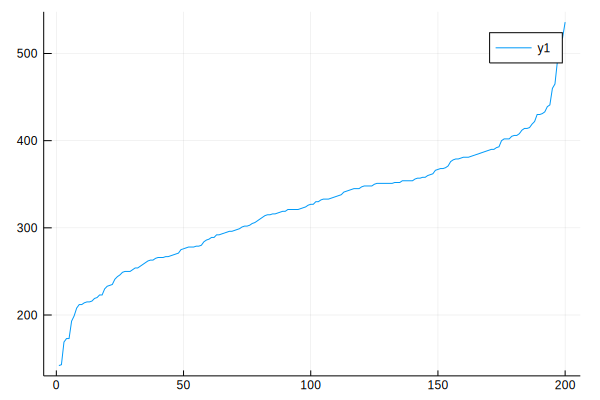

In [782]:
x = 1:length(v)
plot(x,v)

In [783]:
vlst = [[minimum(v), Int(round(median(v))), maximum(v)]]

1-element Array{Array{Int64,1},1}:
 [142, 327, 536]

In [788]:
# Proceed generation
# size, counter, survival rate, elite rate, mutation rate
# default rates : 0.8, 0.2, 0.05
# enable jobswitching between available rows
vl = ProcGA.evolution!(ppl, 100,5, 0.2, 0.5, 1, true);
vlst = vcat(vlst,vl);

i:5 => [1, 25, 114]
i:10 => [1, 35, 111]
i:15 => [1, 32, 136]
i:20 => [1, 17, 125]
i:25 => [1, 36, 109]
i:30 => [1, 32, 129]
i:35 => [1, 20, 130]
i:40 => [1, 28, 105]
i:45 => [1, 26, 105]
i:50 => [1, 20, 129]
i:55 => [1, 32, 104]
i:60 => [1, 19, 104]
i:65 => [1, 16, 104]
i:70 => [1, 20, 114]
i:75 => [1, 32, 133]
i:80 => [1, 34, 106]
i:85 => [1, 34, 139]
i:90 => [1, 35, 104]
i:95 => [1, 33, 111]
i:100 => [1, 22, 128]


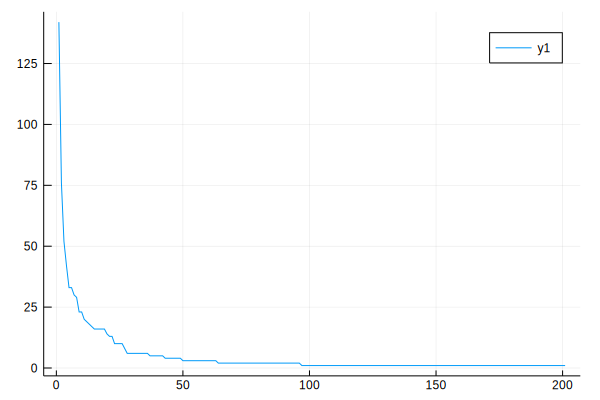

In [789]:
y = (x->x[1]).(vlst);
x = 1:length(y);

plot(x,y)

Pick up the best data.

In [790]:
v = ProcGA.penalty.(ppl)
idm = findmin(v)[2]
bestgen = ppl[idm]

3-element Array{Array{Int64,1},1}:
 [4, 1, 2, 3, 5, 1, 4, 3, 3, 4  …  2, 3, 2, 2, 1, 3, 2, 2, 4, 3]   
 [6, 7, 10, 8, 6, 9, 7, 7, 6, 6  …  6, 6, 10, 8, 7, 7, 11, 6, 0, 0]
 [7, 4, 5, 5, 7, 7, 3, 6, 2, 2  …  1, 2, 3, 1, 2, 2, 6, 1, 3, 0]   

In [799]:
# save best process table to file.
# do not clip it so that it can be used again
writedlm("bestprc.csv",bestgen, ',')

## Check

In [801]:
ProcGA.listcontinuity(bestgen,useday)

3-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We should add penalty to continuous usege over all machines!

In [792]:
plst = ProcGA.listpenalty(bestgen)

3-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [795]:
sum(sum(plst))

0

In [798]:
v = ProcGA.validlength.(bestgen)

3-element Array{Int64,1}:
 36
 34
 35

OK!

All job length are almost same!

## check functions (test)

In [646]:
gs

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [647]:
g2 = deepcopy(gs)

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [649]:
l2 = g2[2];

In [651]:
g2[2] = ProcGA.condensejob!(l2);
g2

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [652]:
vl = ProcGA.validlength(g2)

42

In [655]:
l3 = g2[3][1:vl];
l3 = sort(l3,rev=true);
g2[3][1:vl] = l3
g2

3-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
 [11, 10, 9, 8, 7, 7, 7, 7, 7, 6  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [657]:
l1 = g2[1][1:vl];

In [660]:
t1 = reshape(l1,(2,vl÷ 2))

2×21 Array{Int64,2}:
 1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  5  5
 1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  5  5

7.0

In [474]:
ProcGA.penalty(bestgen) + sum(sum(ProcGA.listzero(bestgen)))

475

In [509]:
push!(ppl,gnew);

Adjust length of each row

In [476]:
x = [1,2,3];
[x for i in 1:3]

3-element Array{Array{Int64,1},1}:
 [1, 2, 3]
 [1, 2, 3]
 [1, 2, 3]

In [433]:
Int(round(std(l)))*3

45

In [328]:
checkpenalties.([ppl[2],ppl[3]])

2-element Array{NTuple{4,Int64},1}:
 (252, 0, 0, 80)
 (252, 0, 0, 80)

In [329]:
checkpenalties.([c1,c2])

2-element Array{NTuple{4,Int64},1}:
 (273, 0, 0, 80) 
 (252, 60, 0, 80)

In [330]:
ProcGA.switchjob!(c1)

3×294 Array{Int64,2}:
 0  0  0  0  1  0  0  1  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  2  0  0  4  0  0  5  5     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  0  1  1  0  1  1  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0

In [331]:
checkpenalties(c1)

(273, 0, 0, 80)

In [240]:
function switchjob1!(jtbl::Array{Int,2}, atbl = ProcGA.assigntable)
    rw = size(jtbl,1)
    col = ProcGA.validlength(jtbl)
    
    r1 = rand(1:rw)
    c1 = rand(1:col)
    r2 = sample(ProcGA.findassignnum(r1,atbl),1)[1]
    c2 = sample(1:col,1)[1]
    jtbl[r1,c1],jtbl[r2,c2] = jtbl[r2,c2], jtbl[r1,c1]
    println("($r1,$c1): <=> ($r2,$c2)")
    jtbl[r1,c1], jtbl[r2,c2]
end

switchjob1! (generic function with 2 methods)

In [332]:
switchjob1!(c1)

(2,166): <=> (3,31)


(1, 0)

In [333]:
checkpenalties(c2)

(252, 60, 0, 80)